In [1]:
!conda env export > xml_met_environment.yml
import pandas
import matplotlib as plt
import glob
import os
data_directory = "/mnt/hgfs/shared/weather_warnings/archive_warnings/archive"
full_path = os.path.abspath(data_directory)
print(f"Full path: {full_path}")

if os.path.exists(data_directory):
    print(f"Directory exists: {data_directory}")
else:
    print(f"Directory does not exist: {data_directory}")
print(os.getcwd())

Full path: /mnt/hgfs/shared/weather_warnings/archive_warnings/archive
Directory exists: /mnt/hgfs/shared/weather_warnings/archive_warnings/archive
/mnt/hgfs/shared/ul_project_Msc_AI/data/met_eireann/eda


Weather Advisories

Weather Advisories are issued up to about a week ahead to provide early information on potential hazardous weather. They may also be employed when a sum of weather elements acting together create a significant hazard, e.g. winds which may not be up to warnings strength but which, when combined with high tides and significant swell, generate a risk of flooding. Another possible use would be to advise of wind speed and direction on occasions of Volcanic Ash contamination. They might also be used to advise of expected significant medium-term accumulations of rain during a very unsettled period, when soils are known to be saturated. The issue of Weather Warnings and Weather Advisories is at all times down to the judgement of the Met Éireann Meteorologists/Forecasters.
When Will The Weather Warnings Be Issued?

In general Weather Warnings will be issued whenever weather conditions meeting the detailed thresholds defined below are anticipated within a 60-hr period. There will be judgement required on the part of the forecaster who must weigh up the possible severity of the weather conditions and the likelihood of their occurrence. However on some occasions (weekends, holiday periods) it may be necessary to issue Weather Warnings beyond this 60-hr horizon, if sufficient certainty derives from examination of the weather charts. Normally, however, a Weather Advisory (see above) will be used to flag severe weather beyond 60 hrs and Advisories will normally anticipate only “Orange” or “Red” criteria weather hazards.

Given that the thrust of the Weather Warnings service is on potential “Impacts” of weather rather than on the numerical values attained by the weather elements themselves, it may on occasion be appropriate to issue warnings at a level higher than that strictly justified by the anticipated weather elements. An example would be when heavy rain was expected which might not quite meet the “Orange Warning” criteria but which might give rise to significant flooding because of already saturated ground, or because of a combination of rain, wind and tide in a coastal location.
Weather Warning Criteria

The criteria for the different warnings levels (Yellow, Orange, Red) and the different weather elements are laid out in the tables below.

IMPACT CONSIDERATIONS: These numerical criteria are strong guidelines but impacts from wind/rain/snow etc., vary depending on location, recent weather conditions, the state of ground, the time of year as well as the duration of the event. In any individual weather event, not every location in the warning area may experience the same degree of weather or impacts. When severe weather is expected, weather and impacts at lower levels are also likely to be experienced.

In [1]:
## Useful info on xml files
## https://www.met.ie/Open_Data/Warnings/Met_Eireann_Warning_description_June2020.pdf
## http://www.statoids.com/uie.html
#Yellow 	Not unusual weather. Localised danger.
#Orange 	Infrequent. Dangerous / disruptive.
#Red 	Rare. Extremely dangerous / destructive.

import xml.etree.ElementTree as ET
import pandas as pd
from datetime import datetime, timezone
import glob
import os
from tqdm import tqdm
import codecs
import csv

# County information dictionary
county_info = {
    'EI01': 'Carlow', 'EI02': 'Cavan', 'EI03': 'Clare', 'EI04': 'Cork', 'EI32': 'Cork City',
    'EI06': 'Donegal', 'EI33': 'Dublin City', 'EI34': 'Dún Laoghaire-Rathdown', 'EI35': 'Fingal',
    'EI10': 'Galway', 'EI36': 'Galway City', 'EI11': 'Kerry', 'EI12': 'Kildare', 'EI13': 'Kilkenny',
    'EI15': 'Laois', 'EI14': 'Leitrim', 'EI42': 'Limerick', 'EI37': 'Limerick City', 'EI18': 'Longford',
    'EI19': 'Louth', 'EI20': 'Mayo', 'EI21': 'Meath', 'EI22': 'Monaghan', 'EI23': 'Offaly',
    'EI24': 'Roscommon', 'EI25': 'Sligo', 'EI39': 'South Dublin', 'EI43': 'Tipperary',
    'EI44': 'Waterford', 'EI29': 'Westmeath', 'EI30': 'Wexford', 'EI31': 'Wicklow'
}

def parse_xml(file_path):
    """
    Parse an XML file and extract relevant information.
    
    Args:
    file_path (str): Path to the XML file
    
    Returns:
    dict: Parsed data from the XML file
    None: If there's an error in parsing
    """
    try:
        # Read the file content
        with codecs.open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            xml_content = file.read()
        
        # Parse the XML content
        root = ET.fromstring(xml_content)
        namespace = {'cap': 'urn:oasis:names:tc:emergency:cap:1.2'}
        
        # Extract data from the root level
        row = {
            'identifier': get_element_text(root, 'cap:identifier', namespace),
            'sender': get_element_text(root, 'cap:sender', namespace),
            'sent': get_element_text(root, 'cap:sent', namespace),
            'status': get_element_text(root, 'cap:status', namespace),
            'msgType': get_element_text(root, 'cap:msgType', namespace),
            'scope': get_element_text(root, 'cap:scope', namespace),
        }
        
        # Extract data from the info element
        info = root.find('cap:info', namespace)
        if info is not None:
            row.update({
                'language': get_element_text(info, 'cap:language', namespace),
                'category': get_element_text(info, 'cap:category', namespace),
                'event': get_element_text(info, 'cap:event', namespace),
                'responseType': get_element_text(info, 'cap:responseType', namespace),
                'urgency': get_element_text(info, 'cap:urgency', namespace),
                'severity': get_element_text(info, 'cap:severity', namespace),
                'certainty': get_element_text(info, 'cap:certainty', namespace),
                'effective': get_element_text(info, 'cap:effective', namespace),
                'onset': get_element_text(info, 'cap:onset', namespace),
                'expires': get_element_text(info, 'cap:expires', namespace),
                'senderName': get_element_text(info, 'cap:senderName', namespace),
                'headline': get_element_text(info, 'cap:headline', namespace),
                'description': get_element_text(info, 'cap:description', namespace),
                'instruction': get_element_text(info, 'cap:instruction', namespace),
            })
            
            # Extract parameters
            parameters = info.findall('cap:parameter', namespace)
            for param in parameters:
                name = get_element_text(param, 'cap:valueName', namespace)
                value = get_element_text(param, 'cap:value', namespace)
                if name and value:
                    row[f'param_{name}'] = value
            
            # Extract area information
            area = info.find('cap:area', namespace)
            if area is not None:
                row['areaDesc'] = get_element_text(area, 'cap:areaDesc', namespace)
                geocodes = area.findall('cap:geocode', namespace)
                if geocodes:
                    geocode_values = [get_element_text(gc, 'cap:value', namespace) for gc in geocodes if get_element_text(gc, 'cap:valueName', namespace) == 'FIPS']
                    row['counties'] = ';'.join([county_info.get(gc, gc) for gc in geocode_values if gc in county_info])
                else:
                    row['counties'] = 'All'
        
        return row
    
    except ET.ParseError as e:
        return None
    except Exception as e:
        return None

def get_element_text(parent, element_name, namespace):
    """
    Extract text from an XML element
    
    Args:
    parent (Element): Parent XML element
    element_name (str): Name of the child element to extract
    namespace (dict): XML namespace
    
    Returns:
    str: Text content of the element, or None if not found
    """
    element = parent.find(element_name, namespace)
    return element.text if element is not None else None

def process_files(data_directory_xml):
    """
    Process all XML files in the given directory and extract weather warning data.
    
    Args:
    data_directory (str): Path to the directory containing XML files
    
    Returns:
    tuple: (DataFrame of parsed data, list of error files)
    """
    file_pattern = os.path.join(data_directory_xml, '*.xml')
    file_list = glob.glob(file_pattern)

    data = []
    error_files = []

    for file in tqdm(file_list, desc="Processing files"):
        row = parse_xml(file)
        if row is not None:
            data.append(row)
        else:
            error_files.append(file)

    # Create DataFrame
    df_xml = pd.DataFrame(data)

    # Convert date fields to datetime
    date_columns = ['sent', 'effective', 'onset', 'expires']
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], utc=True, errors='coerce')

    # Apply standardization
    df_xml = df_xml.apply(standardize_warning, axis=1)

    return df_xml, error_files

def standardize_warning(row):
    """
    Standardize the warning level and type based on the parsed data.
    
    Args:
    row (dict): A dictionary containing parsed warning data
    
    Returns:
    dict: The input dictionary with added standardized fields
    """
    # Standardize level
    param_awareness_level = str(row.get('param_awareness_level', ''))
    severity = str(row.get('severity', ''))
    
    if 'orange' in param_awareness_level.lower() or 'severe' in severity.lower():
        row['standardized_level'] = 'Orange'
    elif 'red' in param_awareness_level.lower() or 'extreme' in severity.lower():
        row['standardized_level'] = 'Red'
    else:
        row['standardized_level'] = 'Yellow'

    # Standardize severity
    row['standardized_severity'] = severity if severity else 'Unknown'

    # Standardize type - this list is from the met-eireann warning specification
    type_mapping = {
        '1': 'Wind',
        '2': 'Snow-Ice',
        '3': 'Thunderstorm',
        '4': 'Fog',
        '5': 'High-Temperature',
        '6': 'Low-Temperature',
        '10': 'Rain',
        '22': 'Advisory',
        '23': 'Hail'
    }
    
    param_awareness_type = str(row.get('param_awareness_type', ''))
    event = str(row.get('event', ''))
    
    if param_awareness_type:
        try:
            type_code = param_awareness_type.split(';')[0].strip()
            row['standardized_type'] = type_mapping.get(type_code, param_awareness_type)
        except:
            row['standardized_type'] = 'Unknown'
    elif event:
        event_lower = event.lower()
        if 'wind' in event_lower:
            row['standardized_type'] = 'Wind'
        elif 'rain' in event_lower:
            row['standardized_type'] = 'Rain'
        elif 'snow' in event_lower or 'ice' in event_lower:
            row['standardized_type'] = 'Snow-Ice'
        elif 'thunder' in event_lower:
            row['standardized_type'] = 'Thunderstorm'
        elif 'fog' in event_lower:
            row['standardized_type'] = 'Fog'
        elif 'temperature' in event_lower:
            if 'high' in event_lower:
                row['standardized_type'] = 'High-Temperature'
            elif 'low' in event_lower:
                row['standardized_type'] = 'Low-Temperature'
        elif 'hail' in event_lower:
            row['standardized_type'] = 'Hail'
        else:
            row['standardized_type'] = 'Other'
    else:
        row['standardized_type'] = 'Unknown'

    return row

def save_error_files(error_files, output_file):
    """
    Save the list of files that couldn't be parsed to a CSV file.
    
    Args:
    error_files (list): List of file paths that couldn't be parsed
    output_file (str): Path to the output CSV file
    """
    with open(output_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Error Files'])
        for file in error_files:
            writer.writerow([file])

def save_sample_warnings(df, output_file, start_year, end_year, count=50):
    """
    Save a sample of warnings from a specific date range to a CSV file.
    
    Args:
    df (DataFrame): DataFrame containing the warning data
    output_file (str): Path to the output CSV file
    start_year (int): Start year for the sample
    end_year (int): End year for the sample
    count (int): Number of samples to save
    """
    mask = (df['sent'].dt.year >= start_year) & (df['sent'].dt.year <= end_year)
    sample = df[mask].sample(min(count, sum(mask)))
    sample.to_csv(output_file, index=False)

# Main script
df, error_files = process_files(data_directory)

# Save the full DataFrame to CSV
df.to_csv('all_weather_warnings.csv', index=False)

# Save error files
save_error_files(error_files, 'error_files.csv')

# Save sample warnings
save_sample_warnings(df, 'pre_2021_warnings.csv', 2017, 2020)
save_sample_warnings(df, 'post_2020_warnings.csv', 2021, df['sent'].dt.year.max())

print("Processing Summary:")
print(f"Total files processed: {len(df) + len(error_files)}")
print(f"Files successfully parsed: {len(df)}")
print(f"Files with errors: {len(error_files)}")

if 'sent' in df.columns:
    print(f"Data covers the period from {df['sent'].min().strftime('%d/%m/%Y')} to {df['sent'].max().strftime('%d/%m/%Y')}")
else:
    print("No valid dates found in the data")

print("\nFull dataset saved to 'all_weather_warnings.csv'")
print("Error files saved to 'error_files.csv'")
print("Sample of pre-2021 warnings saved to 'pre_2021_warnings.csv'")
print("Sample of post-2020 warnings saved to 'post_2020_warnings.csv'")

NameError: name 'data_directory' is not defined

In [1]:
import pandas as pd

# Load the data
df = pd.read_csv('all_weather_warnings.csv')

# Convert 'sent' to datetime
df['sent'] = pd.to_datetime(df['sent'])

# Print the unique values in the 'severity' column
print("Unique severity levels:")
print(df['severity'].unique())

# Count the occurrences of each severity level
print("\nCount of each severity level:")
print(df['severity'].value_counts())

# If there's an 'event' column, let's see how it relates to severity
if 'event' in df.columns:
    print("\nSample of events for each severity level:")
    for severity in df['severity'].unique():
        print(f"\n{severity} warnings:")
        print(df[df['severity'] == severity]['event'].value_counts().head())

# Check if there's any mention of colors in the data
color_keywords = ['yellow', 'orange', 'red']
for keyword in color_keywords:
    if df['description'].notna().any():  # Check if there are any non-null values
        mask = df['description'].fillna('').str.contains(keyword, case=False)
        if mask.any():
            print(f"\nFound mentions of '{keyword}' in descriptions:")
            sample = df[mask].head(1)
            print(sample[['severity', 'description']])
    else:
        print(f"\nNo non-null descriptions found to search for '{keyword}'")

# Print a few rows to see the structure of the data
print("\nSample rows:")
print(df.head())

# Print column names
print("\nColumn names:")
print(df.columns)

Unique severity levels:
['Moderate' 'Severe' 'Extreme' 'Minor']

Count of each severity level:
severity
Moderate    8787
Severe      1579
Extreme      315
Minor         16
Name: count, dtype: int64

Sample of events for each severity level:

Moderate warnings:
event
Moderate Wind warning        1835
Moderate Rainfall warning    1540
Moderate Advisory warning    1222
Moderate  warning            1216
Moderate Snow-ice warning     879
Name: count, dtype: int64

Severe warnings:
event
Severe Wind warning        782
Severe Snow-ice warning    242
Severe  warning            187
Orange Wind                131
Orange Rain                 61
Name: count, dtype: int64

Extreme warnings:
event
Extreme Snow-ice warning    161
Extreme Wind warning         84
Red Wind                     39
Extreme  warning             31
Name: count, dtype: int64

Minor warnings:
event
Minor Rain Warning                   2
Minor Wind Warning                   2
Minor High Temperature Warning       2
Minor Low Tem

Summary Statistics:
Total number of warnings: 6725

Warnings by level:
standardized_level
Yellow    5462
Orange    1106
Red        157
Name: count, dtype: int64

Warnings by type:
standardized_type
Wind                3284
Rain                2042
Snow-Ice             752
Thunderstorm         319
Low-Temperature      183
Fog                   81
High-Temperature      62
Other                  2
Name: count, dtype: int64

Warnings by year:
year
2017     217
2018    1036
2019    1122
2020    1942
2021    1003
2022     895
2023     510
Name: count, dtype: int64


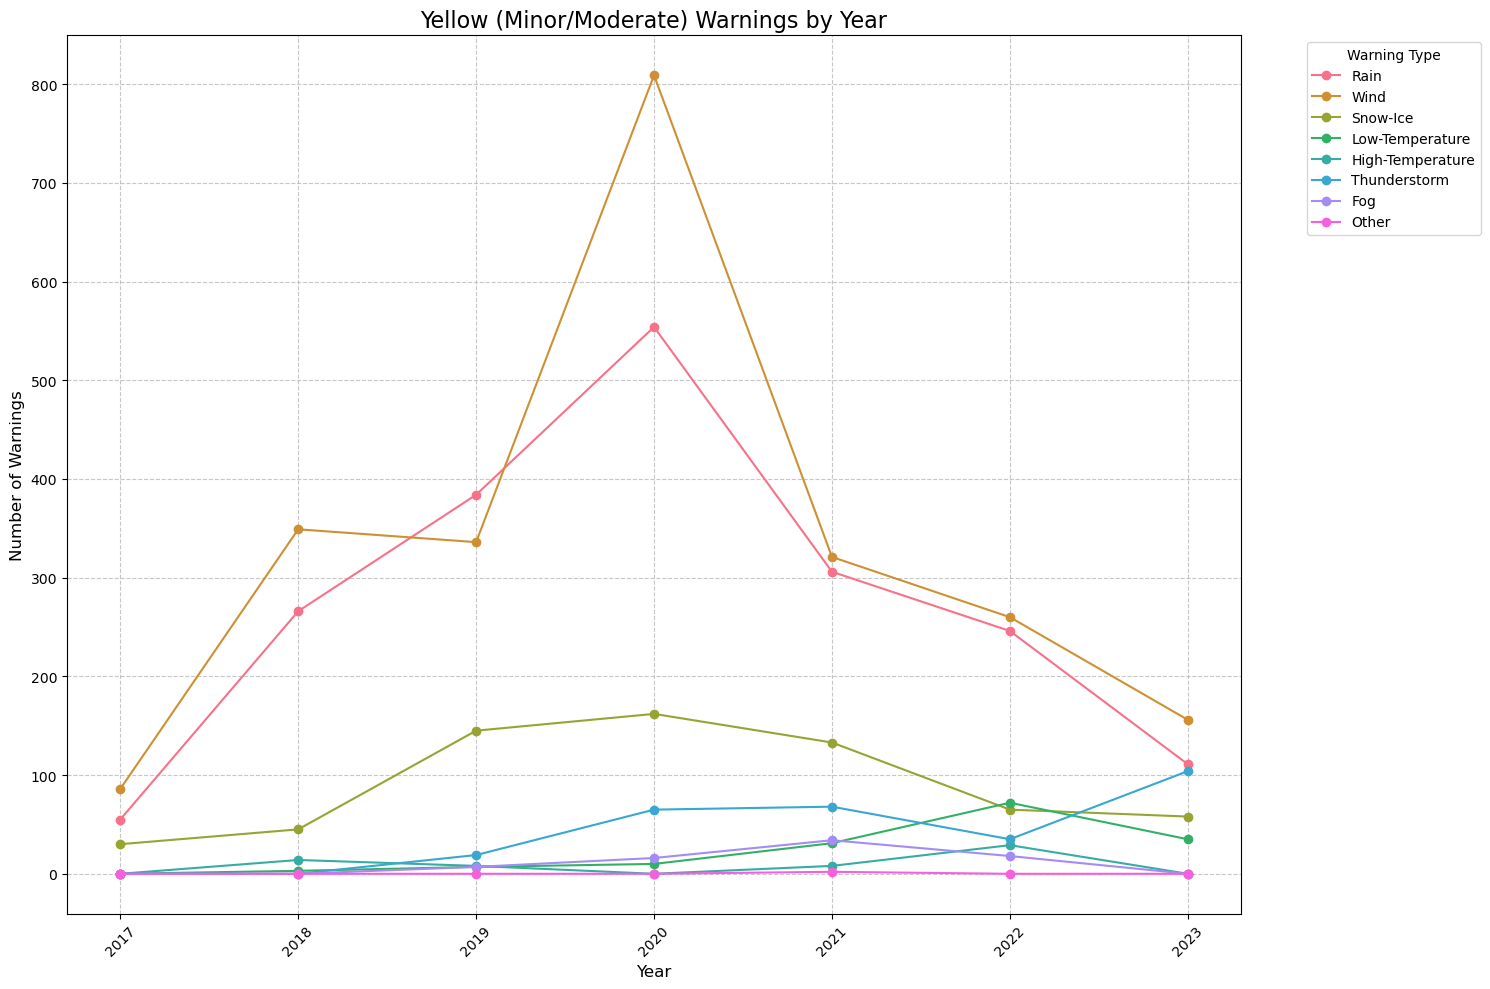

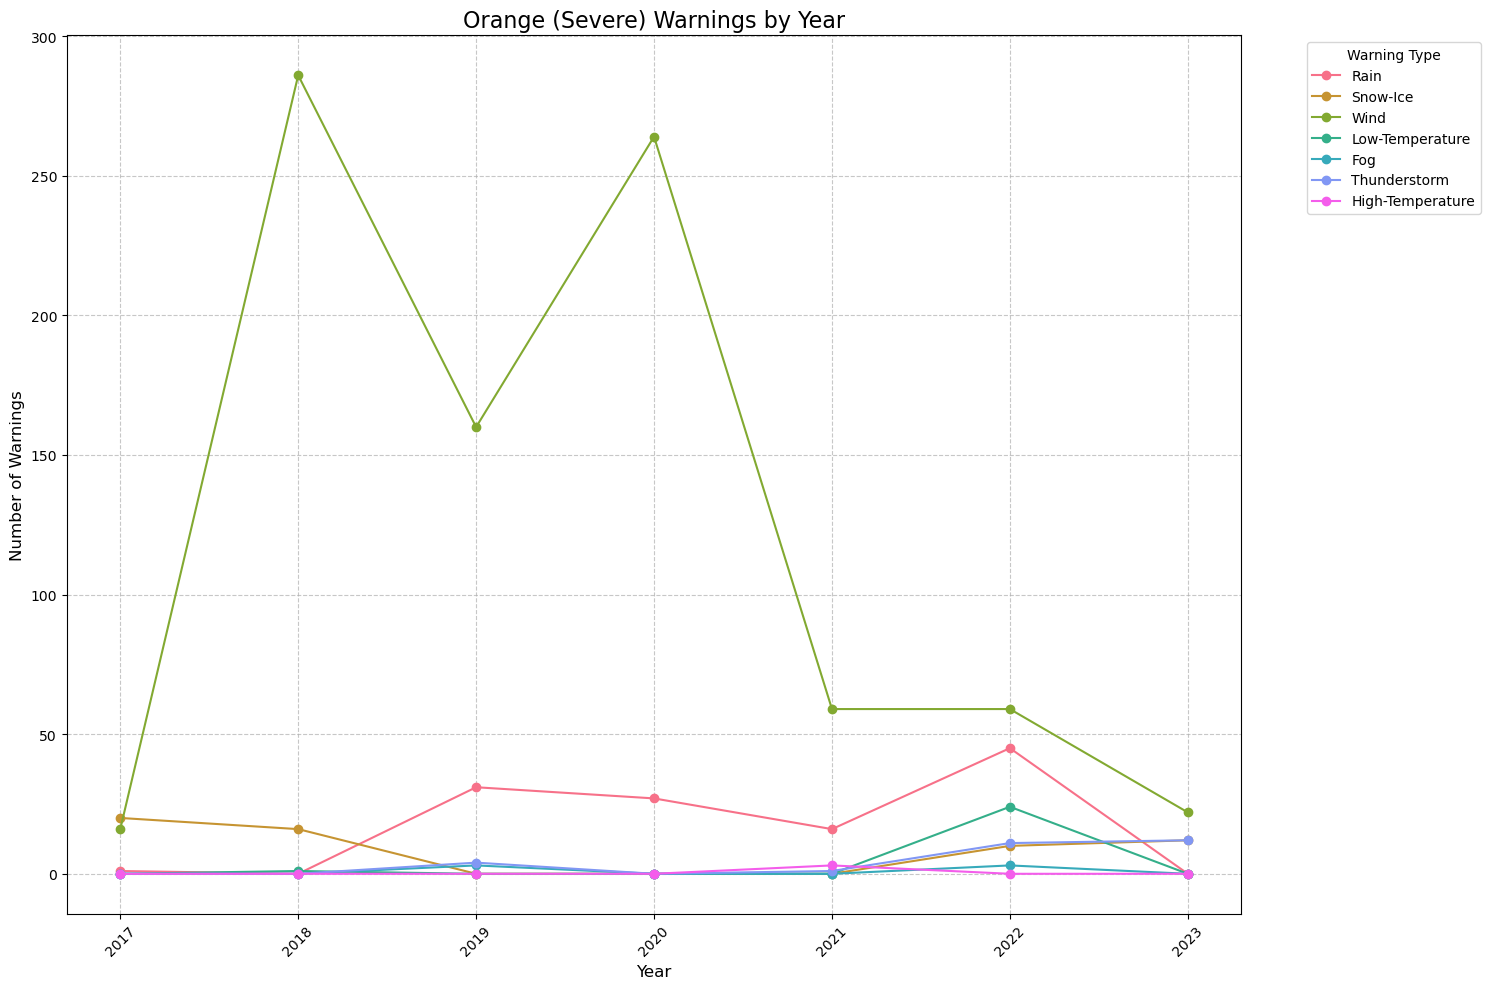

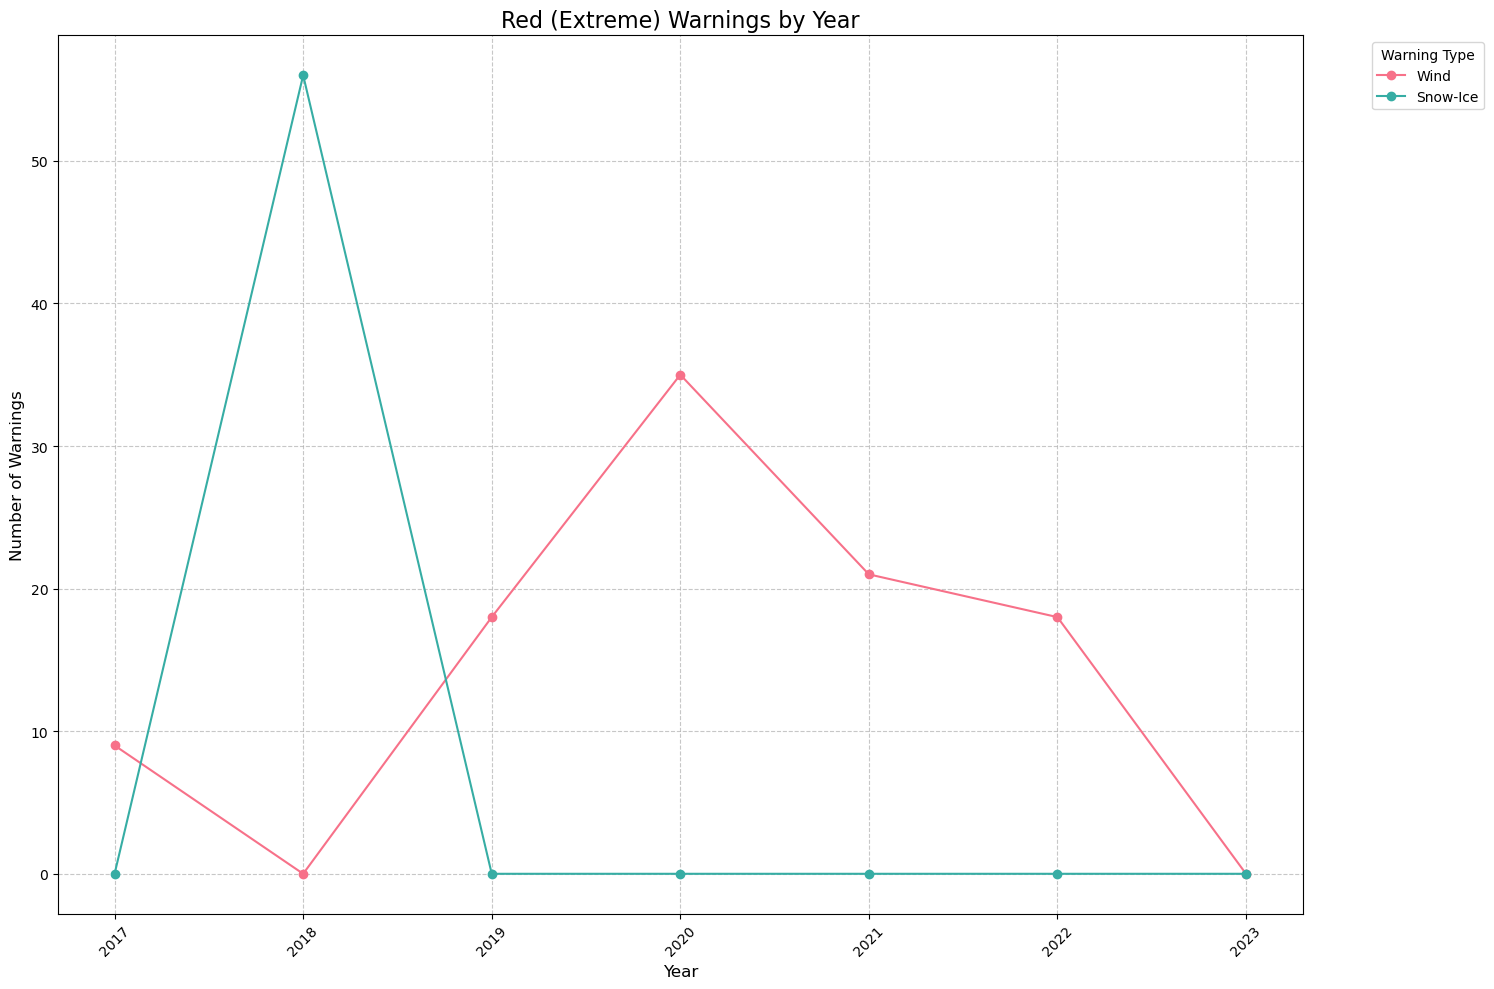

Plots have been displayed and saved as PNG files.

Excluded Data Summary:
Number of advisories excluded: 949
Number of events with no awareness type excluded: 1434


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Assuming df is your DataFrame with the standardized columns

# Convert 'sent' to datetime if it's not already
df['sent'] = pd.to_datetime(df['sent'])

# Extract year from 'sent'
df['year'] = df['sent'].dt.year

def plot_yearly_warnings(df, level, title):
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Filter data for the specific standardized level
    # Exclude advisories and events with no awareness type
    level_df = df[(df['standardized_level'] == level) & 
                  (~df['event'].str.contains('Advisory', case=False, na=False)) & 
                  (df['param_awareness_type'].notna())]
    
    # Get unique standardized types
    event_types = level_df['standardized_type'].unique()
    
    # Color palette
    colors = sns.color_palette("husl", n_colors=len(event_types))
    
    for event_type, color in zip(event_types, colors):
        event_data = level_df[level_df['standardized_type'] == event_type]
        yearly_counts = event_data.groupby('year').size()
        
        # Ensure all years from 2017 to 2023 are represented
        all_years = range(2017, 2024)
        yearly_counts = yearly_counts.reindex(all_years, fill_value=0)
        
        ax.plot(yearly_counts.index, yearly_counts.values, 
                label=event_type, color=color, marker='o')

    ax.set_title(f'{title} Warnings by Year', fontsize=16)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Number of Warnings', fontsize=12)
    ax.legend(title='Warning Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xticks(range(2017, 2024))  # Set x-ticks to years 2017-2023
    ax.set_xticklabels(range(2017, 2024), rotation=45)
    plt.tight_layout()
    
    # Save plot
    plt.savefig(f'{level.lower()}_warnings_yearly.png', dpi=300, bbox_inches='tight')
    
    # Show plot 
    plt.show()

# Function to print summary statistics
def print_summary_stats(df):
    print("Summary Statistics:")
    print(f"Total number of warnings: {len(df)}")
    print("\nWarnings by level:")
    print(df['standardized_level'].value_counts())
    print("\nWarnings by type:")
    print(df['standardized_type'].value_counts())
    print("\nWarnings by year:")
    print(df['year'].value_counts().sort_index())

# Filter out advisories and events with no awareness type
df_filtered = df[(~df['event'].str.contains('Advisory', case=False, na=False)) & 
                 (df['param_awareness_type'].notna())]

# Print summary statistics before plotting
print_summary_stats(df_filtered)

# Create plots for each standardized level
plot_yearly_warnings(df_filtered, 'Yellow', 'Yellow (Minor/Moderate)')
plot_yearly_warnings(df_filtered, 'Orange', 'Orange (Severe)')
plot_yearly_warnings(df_filtered, 'Red', 'Red (Extreme)')

print("Plots have been displayed and saved as PNG files.")

# Print information about excluded data
advisories = df[df['event'].str.contains('Advisory', case=False, na=False)]
no_awareness_type = df[df['param_awareness_type'].isna()]

print("\nExcluded Data Summary:")
print(f"Number of advisories excluded: {len(advisories)}")
print(f"Number of events with no awareness type excluded: {len(no_awareness_type)}")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10697 entries, 0 to 10696
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   identifier             10697 non-null  object             
 1   sender                 10697 non-null  object             
 2   sent                   10697 non-null  datetime64[ns, UTC]
 3   status                 10697 non-null  object             
 4   msgType                10697 non-null  object             
 5   scope                  10697 non-null  object             
 6   language               10697 non-null  object             
 7   category               10697 non-null  object             
 8   event                  10697 non-null  object             
 9   responseType           10697 non-null  object             
 10  urgency                10697 non-null  object             
 11  severity               10697 non-null  object         

In [4]:
import sweetviz
report = sweetviz.analyze(df)
report.show_html(layout="vertical")

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [14]:
import pandas as pd
import numpy as np



NaN count in each column:
identifier                   0
sender                       0
sent                         0
status                       0
msgType                      0
scope                        0
language                     0
category                     0
event                        0
responseType                 0
urgency                      0
severity                     0
certainty                    0
effective                    0
onset                        1
expires                      1
senderName                   0
headline                    23
description               1427
instruction              10697
param_awareness_level        0
areaDesc                  1452
counties                     0
param_awareness_type      1460
param_situation          10669
standardized_level           0
standardized_severity        0
standardized_type            0
dtype: int64

Percentage of NaN values in each column:
identifier                 0.000000
sender         

In [ ]:
columns_to_display = ['identifier','param_awareness_type', 'param_awareness_level', 'severity', 'standardized_level', 'standardized_type', 'sent', 'description']
other_entries = df[df['standardized_type'] == 'Other']
unknown_entries = df[df['standardized_type'] == 'Unknown']
print("Entries classified as 'Other':")
print(other_entries[columns_to_display].to_string())
print(f"\nTotal 'Other' entries: {len(other_entries)}")

print("\nEntries classified as 'Unknown':")
print(unknown_entries[columns_to_display].to_string())
print(f"\nTotal 'Unknown' entries: {len(unknown_entries)}")